In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from spring_rods_system_setup import SpringRodsSystemSetup
from spring_rods_system_solver import SpringRodsSystemSolver
from utils.computational_utils import l2_norm, approximate_in_positions

In [2]:
plt.rcParams.update({
    'axes.grid': True,
    'figure.facecolor': 'white',
    'mathtext.default': 'regular',
})

In [3]:
setup = {
    'interval': (-1, 1),
    'spring_len': 1,
    'material_const': (1, 1),
    'spring_const': (1, 1),
    'body_forces': lambda x: np.where(x < 0, 1, -1)
}

In [4]:
ref_quantization = 1024
quantization_grid = [2, 4, 8, 16, 32, 64, 128, 256, 512]

In [5]:
model = SpringRodsSystemSetup(
    **setup,
    step_size=1 / ref_quantization
)

solver = SpringRodsSystemSolver(model)

reference_solution = np.concatenate(solver())
reference_domain = np.concatenate((model.domain[0], model.domain[1]))

In [6]:
cmap = plt.cm.get_cmap('tab10', len(quantization_grid))

/tmp/ipykernel_14718/3690842560.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(quantization_grid))


100%|██████████| 9/9 [00:49<00:00,  5.45s/it]


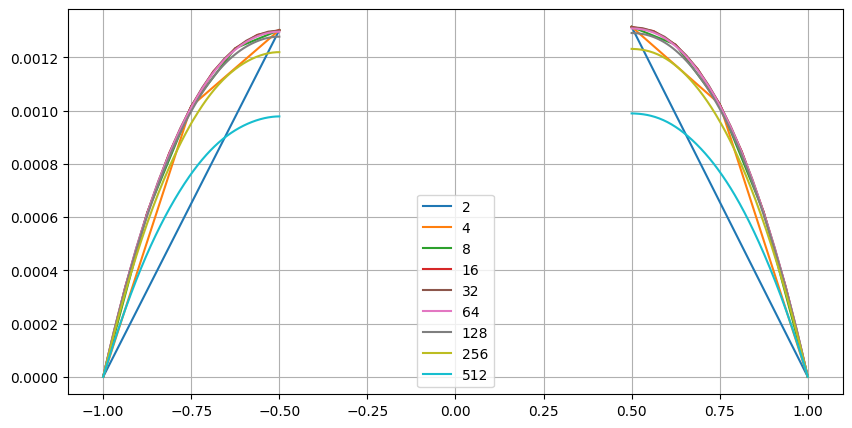

In [7]:
fig = plt.gcf()
fig.set_size_inches(10, 5)

error_norm = []

for idx, quantization in enumerate(tqdm(quantization_grid)):
    model = SpringRodsSystemSetup(
        **setup,
        step_size=1 / quantization
    )
    solver = SpringRodsSystemSolver(model)
    solution = np.concatenate(solver())

    curr_domain = np.concatenate((model.domain[0], model.domain[1]))
    err = solution - approximate_in_positions(reference_solution, reference_domain, curr_domain)
    left_rod_err = err[:model.domain[0].size]
    right_rod_err = err[model.domain[0].size:]

    error_norm.append(l2_norm(values=(left_rod_err, right_rod_err), domain=model.domain))

    plt.plot(model.domain[0], left_rod_err, color=cmap(idx), label=f'{quantization_grid[idx]}')
    plt.plot(model.domain[1], right_rod_err, color=cmap(idx))

plt.legend()

([<matplotlib.axis.YTick at 0x7f25dc47b850>,
 [Text(0, 0.0005345084572773097, '5.35e-04'),
  Text(0, 0.00021656724384382174, '2.17e-04'),
  Text(0, 7.887336818697048e-05, '7.89e-05'),
  Text(0, 2.8081932383177424e-05, '2.81e-05'),
  Text(0, 9.938693128070996e-06, '9.94e-06'),
  Text(0, 3.5031627178777226e-06, '3.50e-06'),
  Text(0, 1.222136405742735e-06, '1.22e-06'),
  Text(0, 4.121696807367539e-07, '4.12e-07'),
  Text(0, 1.1684873026259501e-07, '1.17e-07')])

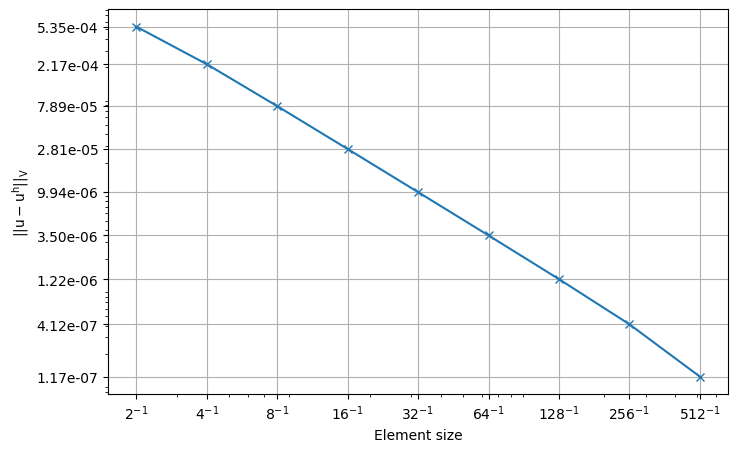

In [8]:
fig = plt.gcf()
fig.set_size_inches(8, 5)

plt.plot(quantization_grid, error_norm, marker='x')
plt.xlabel('Element size')
plt.ylabel('$||u - u^h||_V$')
plt.xscale('log')
plt.yscale('log')
# plt.xticks(quantization_grid, [f'$\\frac{{1}}{{{q}}}$' for q in quantization_grid], fontsize=16)
plt.xticks(quantization_grid, [f'${{{q}}}^{{-1}}$' for q in quantization_grid])
plt.yticks(error_norm, [f'{err:.2e}' for err in error_norm])